# Pipeline to compute attractors/phenotype distribution differences between resistant and sensitive patients and gene differently expression analysis

In [1]:
import pandas as pd

from functions.analysis import downstream_analysis
from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, collect_group_data,  compute_mean_phenotype_values
from functions.analysis_utils.results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from functions.analysis_utils.genes_intervention.pers_interventions import tailor_bnd_genes_intervention
from functions.analysis_utils.stats.stats_proba import compute_mannwhitneyu_test_means


from functions.analysis_utils.results_MaBoSS_visualization.create_phenotypes_patients_table import (
    vizualise_table_phenotype_condition, plot_side_by_side_heatmaps
)

from functions.analysis_utils.gene_enrichment.genes_signature import create_results_gene_enrichment

from functions.analysis_utils.results_MaBoSS_visualization.patients_ids_phenotype_table import create_combined_table_patients

from functions.analysis_utils.stats.stats_proba import compute_power_calculation


### User data parameters

In [2]:
type_models = 'genes_models'  # 'genes_models' or 'proteins_models'


In [3]:
# models inputs

inputs_list = ['EGF', 'FGF', 'TGFB', 'ANDROGEN', 'HYPOXIA', 'NUTRIENTS', 'CARCINOGEN', 'ACIDOSIS', 'TNF', 'SPOP']

# models outputs
phenotype_interest = ["PROLIFERATION","INVASION","DNA_REPAIR","MIGRATION","APOPTOSIS"]

# drug_interest = 'Pictilisib' 
# drug_targets = ['PI3K']
drug_interest = 'AZD7762' 
drug_targets = ['CHK1', 'CHK2']


subdir = f"{'_'.join(drug_targets)}_target_block"



folder_models = f"analysis/{drug_interest}/{type_models}/{subdir}/models"
folder_results = f"analysis/{drug_interest}/{type_models}/{subdir}"





annotations_models = pd.read_csv('data/model_list_20250407.csv')
# Montagud analysis - Growth factors (EGF and FGF), Nutrients and Androgen ON
# Montagud analysis - Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia
list_active_inputs =  [['EGF', 'FGF', 'NUTRIENTS', 'ANDROGEN'], 
                        ['CARCINOGEN', 'ANDROGEN', 'TNF', 'ACIDOSIS', 'HYPOXIA']
                        ]


### Loading the datasets

In [4]:
# Load top patient IDs from files saved in pipeline 1
with open(f"analysis/{drug_interest}/top_resistant_ids.txt") as f:
    top_resistant_ids = [line.strip() for line in f if line.strip()]

with open(f"analysis/{drug_interest}/top_sensitive_ids.txt") as f:
    top_sensitive_ids = [line.strip() for line in f if line.strip()]

### Compute attractors/ phenotypes distribution and differential genes expression

model_pers_bnd analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM00340_AZD7762.bnd
model_pers_cfg analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM00340_AZD7762.cfg
model_pers_bnd analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM00881_AZD7762.bnd
model_pers_cfg analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM00881_AZD7762.cfg
model_pers_bnd analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM00882_AZD7762.bnd
model_pers_cfg analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM00882_AZD7762.cfg
model_pers_bnd analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM01186_AZD7762.bnd
model_pers_cfg analysis/AZD7762/genes_models/CHK1_CHK2_target_block/models/resistant/pers_models/SIDM01186_AZD7762.cfg
model_pers_bnd analysis/AZD7762/genes_models/CHK

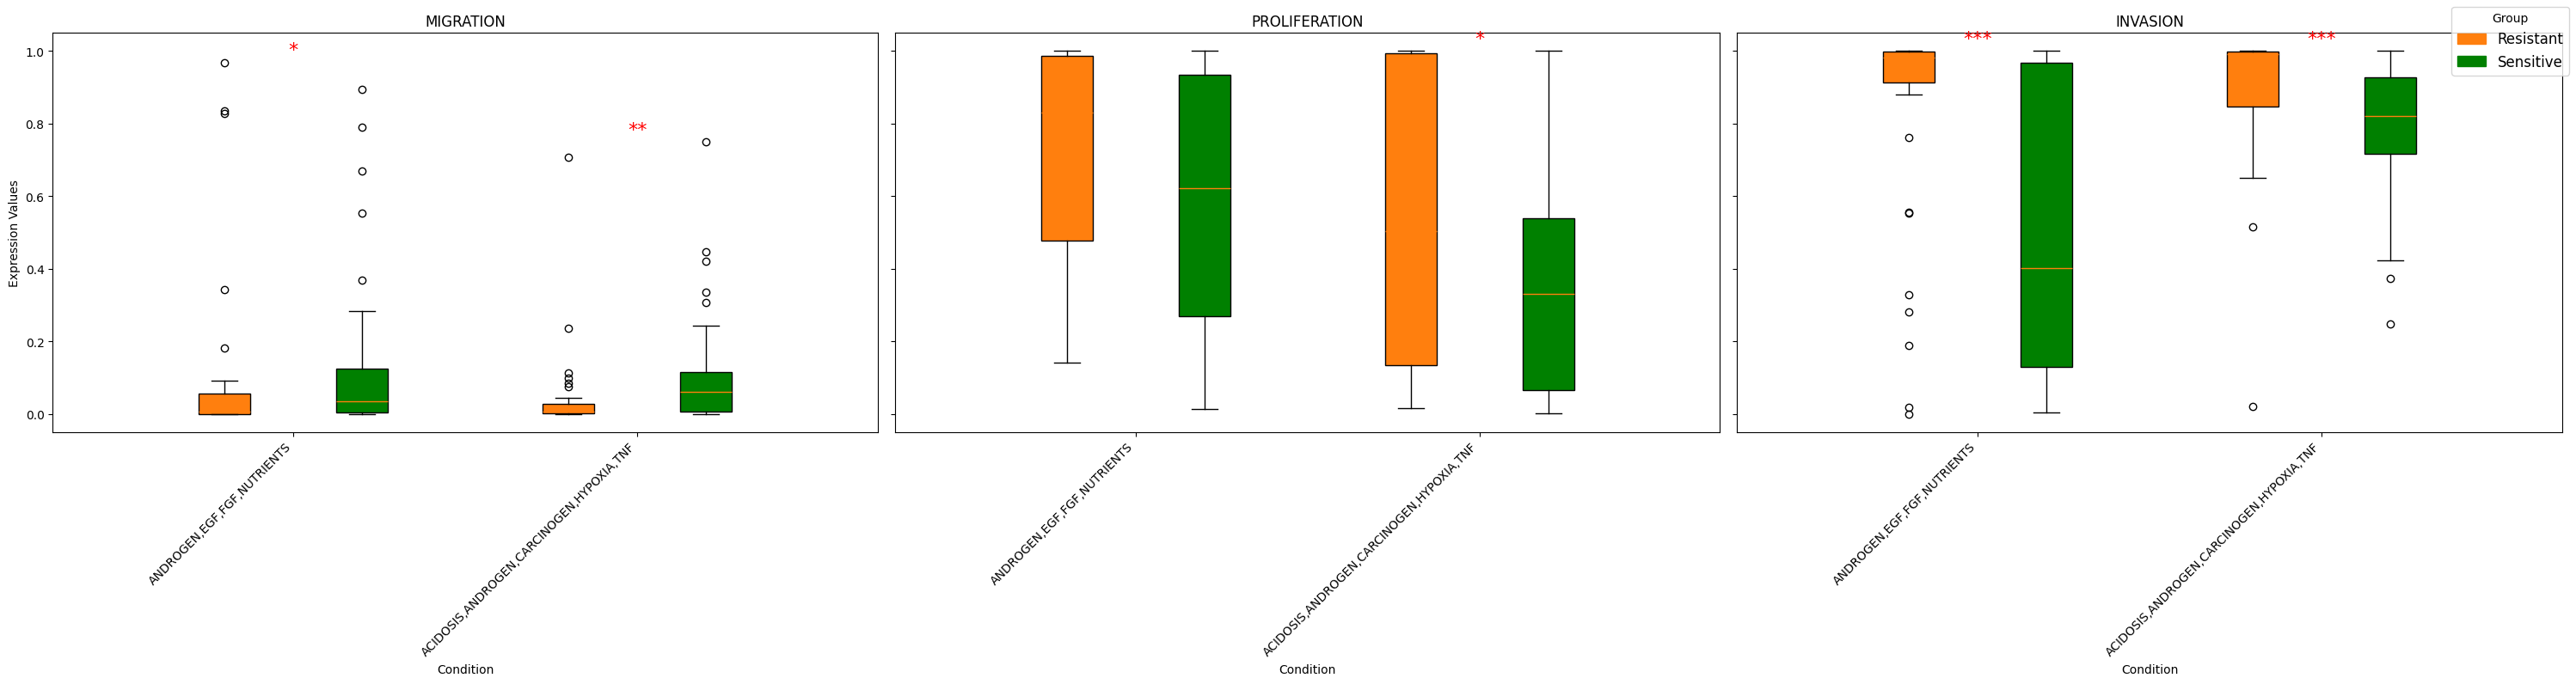

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/MaBoSS_simulation/maboss_phenotype_patient.py:264: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attr

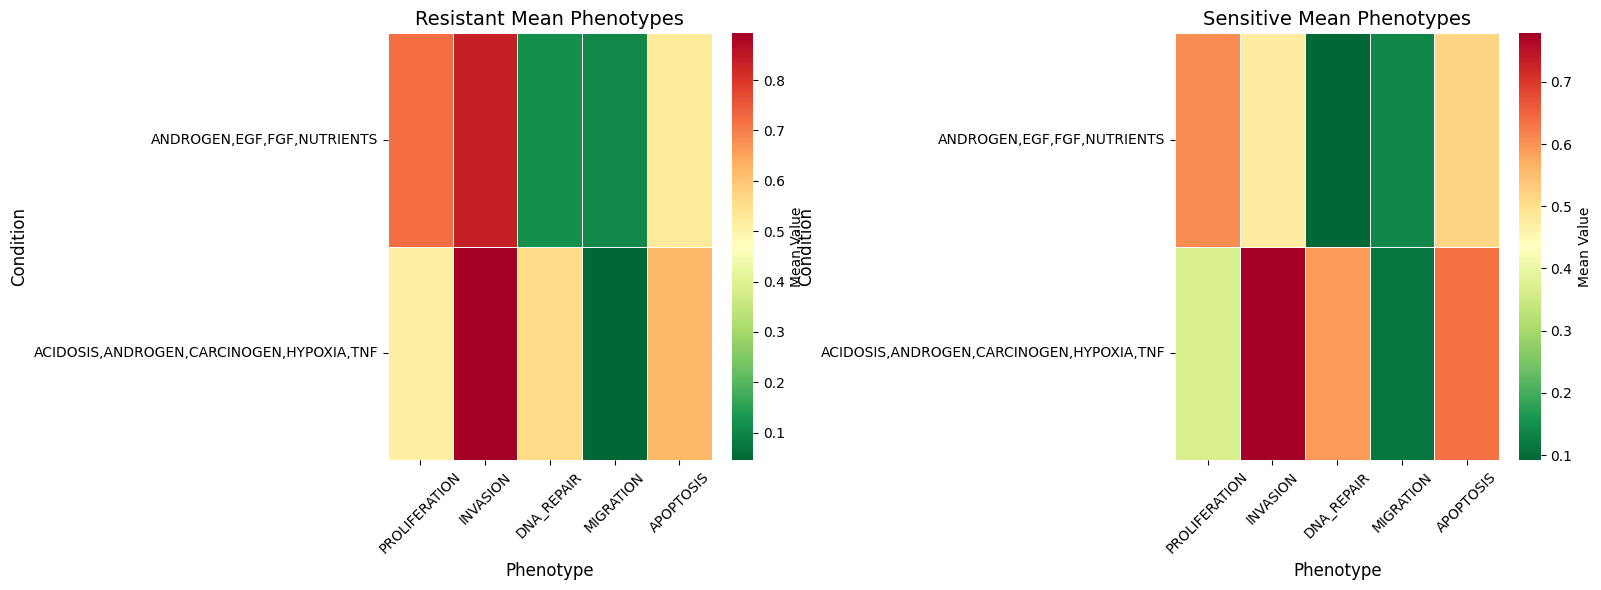

['SIDM00758', 'SIDM00770', 'SIDM00217', 'SIDM00772', 'SIDM01242', 'SIDM00835', 'SIDM00574', 'SIDM00415', 'SIDM00920', 'SIDM00882', 'SIDM00881', 'SIDM00700', 'SIDM00879', 'SIDM00892', 'SIDM00448', 'SIDM01186', 'SIDM00097', 'SIDM01175', 'SIDM00653', 'SIDM00282', 'SIDM00719', 'SIDM01002', 'SIDM00293', 'SIDM00735', 'SIDM00292', 'SIDM00319', 'SIDM00737', 'SIDM00194', 'SIDM00547', 'SIDM00235', 'SIDM00963', 'SIDM00340', 'SIDM00633', 'SIDM00971', 'SIDM01107', 'SIDM00604', 'SIDM01095', 'SIDM00412', 'SIDM00406', 'SIDM00567', 'SIDM00407', 'SIDM01057', 'SIDM00388', 'SIDM00798', 'SIDM00428', 'SIDM00561', 'SIDM00211', 'SIDM00576', 'SIDM00459', 'SIDM01009', 'SIDM00277', 'SIDM01023', 'SIDM00264', 'SIDM00449', 'SIDM00875', 'SIDM01015', 'SIDM01003', 'SIDM01017', 'SIDM00657', 'SIDM01005', 'SIDM01010', 'SIDM01038', 'SIDM01076', 'SIDM01248', 'SIDM00544', 'SIDM00949', 'SIDM00421', 'SIDM00233', 'SIDM00740', 'SIDM00437']
Saved final phenotype table to: analysis/AZD7762/genes_models/CHK1_CHK2_target_block/resu

,PROLIFERATION,INVASION,DNA_REPAIR,MIGRATION,APOPTOSIS
"ANDROGEN,EGF,FGF,NUTRIENTS",107.672234,14.980947,1665.432092,806.104145,25109.15456
"ACIDOSIS,ANDROGEN,CARCINOGEN,HYPOXIA,TNF",98.440661,44.068115,2091.76955,75.788175,6243.712875


In [5]:
# simulate growth factors (EGF and FGF), Nutrients and Androgen ON (cf Montagud paper)
#  simulate with Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia ON. (cf Montagud paper)

nb_patients_required = downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, inputs_list, phenotype_interest, annotations_models, list_active_inputs = list_active_inputs
)

nb_patients_required

In [ ]:
# for each input ON at a time 
nb_patients_required = downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, inputs_list, phenotype_interest, annotations_models, list_active_inputs = None
)

### Power calculation (condition-phenotype size pair)

In [ ]:
nb_patients_required

,PROLIFERATION,INVASION,DNA_REPAIR,MIGRATION,APOPTOSIS
EGF,381.49352,52.55557,484.45204,1624310.141313,239.449024
FGF,1088.08519,42.575028,349.306644,33371.088605,183.85347
TGFB,124.928146,38.550359,447.832795,731.97981,235.387092
ANDROGEN,410.670306,51.666485,490.524038,1732933.194768,254.115656
HYPOXIA,3116.003085,52.906795,527.015117,13891.757899,261.564801
NUTRIENTS,2740.851082,43.373938,544.387771,3385.239942,177.885848
CARCINOGEN,4152.24875,38.63604,353.5927,432.896153,99.834718
ACIDOSIS,592.481438,42.692871,595.003906,8378.571855,260.108446
TNF,66.578799,60.852355,490.715479,11073.312756,156.387984
SPOP,482.835618,56.018762,297.629406,1315.950349,1013.642065
